# Problem Session 12
## Neural Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras import layers

### Carseats Regression Problem

First run the following code to clean the data.

In [2]:
cars = pd.read_csv("../../Data/car_sales.csv")
cars.dropna(inplace = True)

def clean_column(text):
    return float(text.split()[0])

## Cleaning the mileage, engine and max_power columns
cars['mileage'] = cars['mileage'].apply(clean_column)
cars['engine'] = cars['engine'].apply(clean_column)
cars['max_power'] = cars['max_power'].apply(clean_column)

## creating the age column
cars['age'] = 2020 - cars['year']

## performing the log transform on selling_price and km_driven
cars['log_sell'] = np.log10(cars['selling_price'])
cars['log_km'] = np.log10(cars['km_driven'])

## making one-hot encoded variables for transmission, dealer and owner
cars['automatic'] = 1
cars.loc[cars.transmission=='Manual', 'automatic'] = 0

cars[['first_owner', 'second_owner', 'third_owner']] = pd.get_dummies(cars['owner'])[['First Owner', 
                                                                                      'Second Owner',
                                                                                      'Third Owner']]

cars['dealer'] = 1
cars.loc[cars.seller_type == 'Individual', 'dealer'] = 0

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
cars_train, cars_test = train_test_split(cars.copy(),
                                            test_size=.2,
                                            shuffle=True,
                                            random_state=440)
                                    

In [5]:
# Remind yourself about what the data looks like.

features = ['max_power', 'age', 'engine', 'log_km', 'seats', 'dealer', 'automatic', 'mileage']
            
target = ['log_sell']

cars_train[features + target].sample(10)

,max_power,age,engine,log_km,seats,dealer,automatic,mileage,log_sell
3707,79.40,8,1199.0,4.778151,5.0,0,0,18.60,5.255273
6750,68.10,7,1399.0,4.397940,5.0,0,0,20.00,5.397940
4991,120.00,3,2179.0,4.903090,7.0,0,0,15.40,5.949878
1764,67.05,4,1364.0,5.161368,5.0,0,0,23.59,5.755875
3851,88.76,6,1248.0,4.176091,7.0,0,0,20.77,5.653213
2497,73.94,4,1248.0,4.778151,5.0,0,0,23.20,5.602060
6500,98.63,2,1498.0,4.633468,5.0,0,0,27.40,5.845098
58,138.03,2,1798.0,4.397940,5.0,1,1,14.28,6.201397
5687,65.00,9,1172.0,4.845098,5.0,0,0,16.50,5.176091
3789,88.50,3,1248.0,4.819544,7.0,0,0,24.52,5.892095


In [6]:
# Convert everything to numpy arrays

X_train = cars_train[features].values
y_train = cars_train[target].values
X_test = cars_test[features].values
y_test = cars_test[target].values
X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, test_size = 0.2)

Train a vanilla linear regression model on `(X_tt, y_tt)`.  

In [7]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_tt,y_tt)

LinearRegression()

Now try to train a feed forward neural network which has better validation MSE.

Some things to consider:
* How will you address normalization of the input data, if at all?
* How many intermediate layers will you use?  What dimensions will they be?
* What activation functions should you use in the hidden layer?
* What final activation function should you use, if any?
* What loss function should you use?
* What are some other hyperparameters you could play with?

If you are not able to beat linear regression after playing for 20 minutes you should move on.  If you successfully train a neural network and observe the loss going down: count this as a victory!

We will use [early stopping callback](https://keras.io/api/callbacks/early_stopping/).

In [8]:
model = keras.Sequential([
    layers.InputLayer(X_train.shape[1]),
    layers.BatchNormalization(axis = -1),
    layers.Dense(10, activation = 'relu'),
    layers.Dense(1) 
])

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.compile(optimizer = "adam", loss = "mse")

history = model.fit(X_tt, y_tt, epochs = 500, validation_data = (X_val, y_val), batch_size = 32, callbacks=[callback])

Epoch 1/500
159/159 [==============================] - 0s 1ms/step - loss: 24.9286 - val_loss: 15.0062
Epoch 2/500
159/159 [==============================] - 0s 581us/step - loss: 8.9760 - val_loss: 4.2936
Epoch 3/500
159/159 [==============================] - 0s 561us/step - loss: 3.4574 - val_loss: 2.6457
Epoch 4/500
159/159 [==============================] - 0s 556us/step - loss: 2.2373 - val_loss: 1.8318
Epoch 5/500
159/159 [==============================] - 0s 556us/step - loss: 1.5863 - val_loss: 1.2401
Epoch 6/500
159/159 [==============================] - 0s 654us/step - loss: 1.1417 - val_loss: 0.8416
Epoch 7/500
159/159 [==============================] - 0s 623us/step - loss: 0.8042 - val_loss: 0.5752
Epoch 8/500
159/159 [==============================] - 0s 602us/step - loss: 0.5644 - val_loss: 0.3918
Epoch 9/500
159/159 [==============================] - 0s 595us/step - loss: 0.4253 - val_loss: 0.2648
Epoch 10/500
159/159 [==============================] - 0s 596us/step - l

In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
print(mean_squared_error(y_val, model.predict(X_val)))
print(mean_squared_error(y_val, lr.predict(X_val)))

40/40 [==============================] - 0s 431us/step
0.01572929589477998
0.01610823614172302


In [11]:
# Alternatively use model.evaluate
model.evaluate(X_val, y_val)

40/40 [==============================] - 0s 418us/step - loss: 0.0157


0.01572929508984089

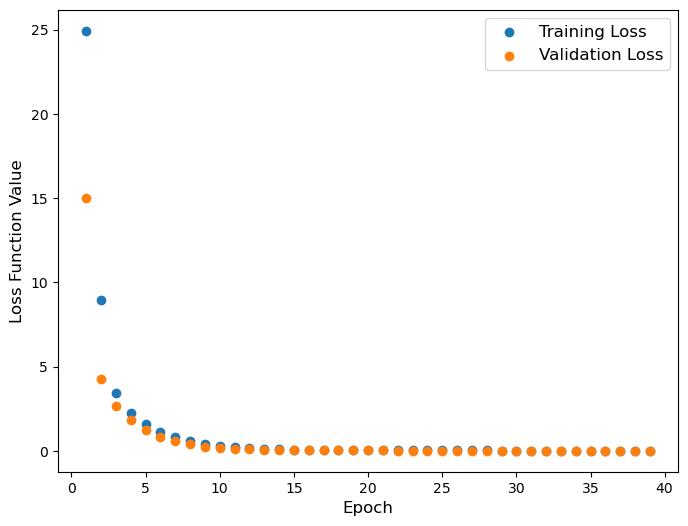

In [12]:
## Plotting the training and validation loss
plt.figure(figsize = (8,6))
epochs = len(history.history['val_loss'])
plt.scatter(range(1, epochs + 1),history.history['loss'], label = "Training Loss")
plt.scatter(range(1, epochs + 1),history.history['val_loss'], label = "Validation Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

Once you are satisfied, check to see if the test MSE of the neural network model still beats linear regression.

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
print(model.evaluate(X_test, y_test))
print(mean_squared_error(y_test, lr.predict(X_test)))

50/50 [==============================] - 0s 451us/step - loss: 0.0169
0.016887834295630455
0.017423672391001087


### Forest Cover Classification Problem

In this problem we will build a feed forward neural network to classify forest cover type.

In [15]:
#!pip install ucimlrepo

In [16]:
# This cell took about 7 minutes to run for me!

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
covertype = fetch_ucirepo(id=31) 
  
# data (as pandas dataframes) 
X = covertype.data.features 
y = covertype.data.targets 
  
# metadata 
print(covertype.metadata) 
  
# variable information 
print(covertype.variables) 

{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 216)
X_tt, X_val, y_tt, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state = 216)
X_tt.sample(5)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
415869,2833,184,10,190,58,1842,222,247,157,2177,...,0,0,0,0,0,0,0,0,1,0
461123,3338,101,10,30,-5,4463,236,227,121,4062,...,0,0,0,0,0,0,0,0,1,0
343479,3334,348,19,60,17,3969,180,204,160,938,...,0,0,0,0,1,0,0,0,0,0
345480,2904,282,19,518,258,1315,163,237,212,1827,...,0,0,0,0,0,0,0,0,1,0
573029,2714,238,25,234,117,2960,166,252,215,1430,...,0,0,0,0,0,0,0,0,1,0


In [18]:
# Making everything into numpy arrays
X_train = X_train.values
X_tt = X_tt.values
X_val = X_val.values
X_test = X_test.values

# Adjusting class labels to go from 0 to 6 instead of 1 to 7.  Keras expects this.
y_train = y_train.values.reshape(-1) - 1
y_tt = y_tt.values.reshape(-1) - 1
y_val = y_val.values.reshape(-1) - 1
y_test = y_test.values.reshape(-1) - 1

Neural Networks are not a good choice for tabular data like this:  something like XGBoost is much better.  A "default settings" random forest classifier gets around 95% accuracy for this problem.

The first dense feed forward NN I wrote down got 78% validation accuracy.  Can you beat that?

Some things to consider:
* Since this is a multiclass classification problem you want to use 'softmax' as your final activation function.
    * Discussion question:  why do we need a final activation function?  Why not use 'sigmoid'?
* Since your class labels are encoded as the integers $0,1,2,3,4,5,6$, you want to use  ['sparse_categorical_crossentropy'](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) as your loss and ['sparse_categorical_accuracy'](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/sparse_categorical_accuracy) as your metric when you compile the model.

In [19]:
# This took about 5 minutes to run.

clf = keras.Sequential([
    layers.InputLayer(X_tt.shape[1]),
    layers.BatchNormalization(axis = -1),
    layers.Dense(20, activation = 'relu'),
    layers.Dense(20, activation = 'relu'),
    layers.Dense(7, activation =  'softmax') 
])

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

clf.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = 'sparse_categorical_accuracy')

history = clf.fit(X_tt, y_tt, epochs = 500, validation_data = (X_val, y_val), batch_size = 32, callbacks=[callback])

Epoch 1/500
11621/11621 [==============================] - 7s 586us/step - loss: 0.6433 - sparse_categorical_accuracy: 0.7257 - val_loss: 0.5896 - val_sparse_categorical_accuracy: 0.7530
Epoch 2/500
11621/11621 [==============================] - 7s 576us/step - loss: 0.5855 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.5690 - val_sparse_categorical_accuracy: 0.7619
Epoch 3/500
11621/11621 [==============================] - 7s 592us/step - loss: 0.5692 - sparse_categorical_accuracy: 0.7566 - val_loss: 0.5618 - val_sparse_categorical_accuracy: 0.7648
Epoch 4/500
11621/11621 [==============================] - 7s 580us/step - loss: 0.5595 - sparse_categorical_accuracy: 0.7599 - val_loss: 0.5941 - val_sparse_categorical_accuracy: 0.7728
Epoch 5/500
11621/11621 [==============================] - 7s 576us/step - loss: 0.5516 - sparse_categorical_accuracy: 0.7627 - val_loss: 0.5424 - val_sparse_categorical_accuracy: 0.7789
Epoch 6/500
11621/11621 [==============================] - 7s 578

In [20]:
clf.evaluate(X_val, y_val.reshape(-1) )

2906/2906 [==============================] - 1s 370us/step - loss: 0.5430 - sparse_categorical_accuracy: 0.7871


[0.5429797172546387, 0.7870957851409912]

In [21]:
clf.evaluate(X_test, y_test.reshape(-1) )

3632/3632 [==============================] - 1s 354us/step - loss: 0.5443 - sparse_categorical_accuracy: 0.7834


[0.5443335771560669, 0.7833532691001892]